In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from frechet_fda.data_generation_tools import (
    gen_params_scenario_one,
    gen_truncnorm_pdf_points,
    make_estimated_truncnorm_pdf,
    make_truncnorm_pdf,
)
from frechet_fda.distribution_tools import (
    frechet_mean,
    get_optimal_range,
    inverse_log_qd_transform,
    log_qd_transform,
    make_function_objects,
    mean_func,
)
from frechet_fda.fda_tools import (
    compute_centered_data,
    compute_cov_function,
    compute_principal_components,
    gen_qdtransformation_pcs,
    k_optimal,
    karhunen_loeve,
    mode_of_variation,
    total_frechet_variance,
)

In [ ]:
# Set parameters
n = 200
grid_size = 10000
trunc = 3
mus, sigmas = gen_params_scenario_one(n)
# Sort sigmas, because when summing Function instances something goes wrong otherwise
sigmas.sort()

In [ ]:
# Generate pdfs within truncation points
pdfs = make_truncnorm_pdf(
    -trunc, trunc, mus, sigmas, grid_size=grid_size, warn_irregular_densities=False,
)
# Make Function class objects
my_pdfs = make_function_objects(pdfs)
my_cdfs = [pdf.integrate() for pdf in my_pdfs]
my_qfs = [cdf.invert() for cdf in my_cdfs]
my_qdfs = [qf.differentiate() for qf in my_qfs]
# For numerical correction: shorten the range for smaller sigmas to get rid of
# numerical artifacts when computing integrals, derivatives and means later
new_ranges = get_optimal_range(my_pdfs)
# Generate pdfs again, this time within individual ranges
pdfs2 = [
    make_truncnorm_pdf(
        new_ranges[i][0],
        new_ranges[i][1],
        mus[i],
        sigmas[i],
        grid_size=grid_size,
        warn_irregular_densities=False,
    )[0]
    for i in range(n)
]

In [ ]:
# Generate all the distribution objects
new_pdfs = make_function_objects(pdfs2)
new_cdfs = [pdf.integrate() for pdf in new_pdfs]
new_qfs = [cdf.invert() for cdf in new_cdfs]
new_qdfs = [qf.differentiate() for qf in new_qfs]

In [ ]:
# Compute centered data, just to see whether it works
# One can clearly see how inappropriate it is to apply fda methods on densities
mean_pdf, centered_pdfs = compute_centered_data(new_pdfs)
centered_pdfs[sigmas.argmin()].compare(new_pdfs[sigmas.argmin()])

In [ ]:
covariance_function = compute_cov_function(centered_pdfs)

In [ ]:
eigenvalues, eigenfunctions = compute_principal_components(
    centered_pdfs[0].x,
    covariance_function,
)

## Transformation FPCA

In [ ]:
# Transform pdf sample, and test whether inverse works
log_qdfs = log_qd_transform(new_pdfs)
inverse_log_qdfs = inverse_log_qd_transform(log_qdfs)
inverse_log_qdfs[0].compare(new_pdfs[0] + 0.05)

In [ ]:
# Compute transformation FPCA objects
pcs_to_compute = 10
(
    mean_log_qdfs,
    eigenvalues_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
) = gen_qdtransformation_pcs(log_qdfs, k=pcs_to_compute)

In [ ]:
# Karhunen-Loève decomposition of transforms
truncation_k = 1
truncated_representations_transforms = karhunen_loeve(
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
    K=truncation_k,
)

In [ ]:
# Transform to density space. Compare truncated representation against real density
truncated_representations = inverse_log_qd_transform(
    truncated_representations_transforms,
)
truncated_representations[150].warp_range(-trunc, trunc).compare(
    new_pdfs[150].warp_range(-trunc, trunc),
    label_self=f"Truncated at K = {truncation_k}",
    label_other="Original Density",
)

In [ ]:
# Look at modes of variance of transformed functions
variation_modes_transforms = [
    mode_of_variation(mean_log_qdfs, eigval, eigfunc, alpha=5e-3)
    for eigval, eigfunc
    in zip(eigenvalues_log_qdfs, eigenfunctions_log_qdfs, strict=True)
]
variation_modes_transforms[0].compare(variation_modes_transforms[1])

In [ ]:
# Translate modes of variation to density space, compare first two modes
variation_modes = inverse_log_qd_transform(variation_modes_transforms)
variation_modes[0].compare(
    variation_modes[1],
    label_self="1st mode",
    label_other="2nd mode",
)

In [ ]:
# Compute Fréchet mean
f_mean = frechet_mean(new_pdfs)
f_mean.warp_range(-trunc, trunc).plot()

In [ ]:
# Compute Fréchet variance
total_variance = total_frechet_variance(f_mean, new_pdfs)

In [ ]:
# Try function that finds optimal trunc representation
optimal_k, fraction_explained, truncated_representations = k_optimal(
    0.5,
    total_variance,
    new_pdfs,
    mean_log_qdfs,
    eigenfunctions_log_qdfs,
    fpc_scores_log_qdfs,
)
optimal_k, fraction_explained

# Simulation

In [ ]:
# Number of simulations
m = 5
sample_sizes = [50, 100, 200]
# Initialize arrays to store Fréchet and cross sectional means
stored_f_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means = np.empty((m, len(sample_sizes)), dtype="object")
stored_f_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")
stored_cs_means_denstimation = np.empty((m, len(sample_sizes)), dtype="object")

In [ ]:
print("Simulating...", end="\r")
for i in range(m):
    # Try different sample sizes
    for j, n in enumerate(sample_sizes):
        # j index only used for storing Fréchet means below!
        # Set parameters
        grid_size = 10000
        trunc = 3
        seed_num = int(str(i) + str(n))  # unique seed in each simulation run
        mus, sigmas = gen_params_scenario_one(n, seed=seed_num)
        # Sort sigmas, because when summing Function instances something goes wrong otherwise
        sigmas.sort()

        # Generate pdfs within truncation points
        pdfs = make_truncnorm_pdf(
            -trunc,
            trunc,
            mus,
            sigmas,
            grid_size=grid_size,
            warn_irregular_densities=False,
        )
        # Make Function class objects
        my_pdfs = make_function_objects(pdfs)

        # For numerical correction: shorten the range for smaller sigmas to get rid of
        # numerical artifacts when computing integrals, derivatives and means later
        new_ranges = get_optimal_range(my_pdfs)
        # Generate pdfs again, this time within individual ranges
        pdfs2 = [
            make_truncnorm_pdf(
                new_ranges[i][0],
                new_ranges[i][1],
                mus[i],
                sigmas[i],
                grid_size=grid_size,
                warn_irregular_densities=False,
            )[0]
            for i in range(n)
        ]

        # Generate numerically stable objects
        new_pdfs = make_function_objects(pdfs2)

        # Compute Fréchet mean
        stored_f_means[i, j] = frechet_mean(new_pdfs)
        stored_cs_means[i, j] = mean_func(new_pdfs)

        # Compute Fréchet variance
        total_variance = total_frechet_variance(stored_f_means[i, j], new_pdfs)

        # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdfs)

        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # # Try function that finds optimal trunc representation
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            0.5,
            total_variance,
            new_pdfs,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )

        ### And now again with additional density estimation step!
        which_kernel = "std_normal"
        sample_points = gen_truncnorm_pdf_points(-trunc, trunc, mus, sigmas, 100)
        pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=-trunc * np.ones(n),
            b=trunc * np.ones(n),
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=0.2,
        )

        new_ranges = get_optimal_range(pdf_hats)
        # Generate numerically stable objects, within individual ranges
        new_pdf_hats = make_estimated_truncnorm_pdf(
            sample_points=sample_points,
            a=new_ranges[:, 0],
            b=new_ranges[:, 1],
            kern=which_kernel,
            grid_size=grid_size,
            bandwidth=0.2,
        )

        # Compute Fréchet mean
        stored_f_means_denstimation[i, j] = frechet_mean(new_pdf_hats)
        stored_cs_means_denstimation[i, j] = mean_func(new_pdf_hats)

        # # Compute Fréchet variance
        total_variance = total_frechet_variance(
            stored_f_means_denstimation[i, j], new_pdf_hats,
        )

        # # Transform pdf sample
        log_qdfs = log_qd_transform(new_pdf_hats)

        (
            mean_log_qdfs,
            eigenvalues_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        ) = gen_qdtransformation_pcs(log_qdfs, k=2)

        # Try function that finds optimal trunc representation. Threshold: explain
        # at least 80 %
        optimal_k, fraction_explained, truncated_representations = k_optimal(
            0.8,
            total_variance,
            new_pdf_hats,
            mean_log_qdfs,
            eigenfunctions_log_qdfs,
            fpc_scores_log_qdfs,
        )
    perc = int(100 * (i + 1) / m)
    print(f"Simulating...{perc}%", end="\r")

In [ ]:
# Calculate true center of distribution for plotting against estimates
std_normal = make_truncnorm_pdf(-trunc, trunc, 0, 1, grid_size=grid_size)[0]

In [ ]:
# Calculate Fréchet means of Fréchet means over all simulations
mean_of_f_means50 = frechet_mean(stored_f_means[:, 0])
mean_of_f_means100 = frechet_mean(stored_f_means[:, 1])
mean_of_f_means200 = frechet_mean(stored_f_means[:, 2])
mean_of_cs_means50 = frechet_mean(stored_cs_means[:, 0])
mean_of_cs_means100 = frechet_mean(stored_cs_means[:, 1])
mean_of_cs_means200 = frechet_mean(stored_cs_means[:, 2])
mean_of_f_means50_denstimation = frechet_mean(stored_f_means_denstimation[:, 0])
mean_of_f_means100_denstimation = frechet_mean(stored_f_means_denstimation[:, 1])
mean_of_f_means200_denstimation = frechet_mean(stored_f_means_denstimation[:, 2])
mean_of_cs_means50_denstimation = frechet_mean(stored_cs_means_denstimation[:, 0])
mean_of_cs_means100_denstimation = frechet_mean(stored_cs_means_denstimation[:, 1])
mean_of_cs_means200_denstimation = frechet_mean(stored_cs_means_denstimation[:, 2])

In [ ]:
# Plot Fréchet means of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(mean_of_f_means50.x, mean_of_f_means50.y, label="Size 50", linestyle="--")
ax.plot(mean_of_f_means100.x, mean_of_f_means100.y, label="Size 100", linestyle="--")
ax.plot(mean_of_f_means200.x, mean_of_f_means200.y, label="Size 200", linestyle="--")
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot Fréchet mean vs cross-sectional mean and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x, mean_of_f_means200.y, label="Fréchet Mean", linestyle="--",
)
ax.plot(
    mean_of_cs_means200.x,
    mean_of_cs_means200.y,
    label="Cross-Sectional Mean",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot Fréchet means from estimated densities and of different sample sizes against true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means50_denstimation.x,
    mean_of_f_means50_denstimation.y,
    label="Size 50",
    linestyle="--",
)
ax.plot(
    mean_of_f_means100_denstimation.x,
    mean_of_f_means100_denstimation.y,
    label="Size 100",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Size 200",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="Black")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot Fréchet mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x,
    mean_of_f_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Plot Fréchet mean with true densities against estimated densities and true center
fig, ax = plt.subplots()
ax.plot(
    mean_of_f_means200.x,
    mean_of_f_means200.y,
    label="True Densities",
    linestyle="--",
)
ax.plot(
    mean_of_f_means200_denstimation.x,
    mean_of_f_means200_denstimation.y,
    label="Estimated Densities",
    linestyle="--",
)
ax.plot(std_normal[0], std_normal[1], label="Standard Normal", color="black")
plt.legend()
plt.grid()
plt.show()

## Implement density estimation step

In [7]:
n = 200
grid_size = 1000
trunc = 3
mus, sigmas = gen_params_scenario_one(n, seed=123456)
# Sort sigmas, because when summing Function instances something goes wrong otherwise
sigmas.sort()

In [8]:
sample_points = gen_truncnorm_pdf_points(-trunc, trunc, mus, sigmas, 100)
pdf_hats = make_estimated_truncnorm_pdf(
    sample_points=sample_points,
    a=-trunc * np.ones(n),
    b=trunc * np.ones(n),
    kern="std_normal",
    grid_size=grid_size,
    bandwidth=0.2,
)

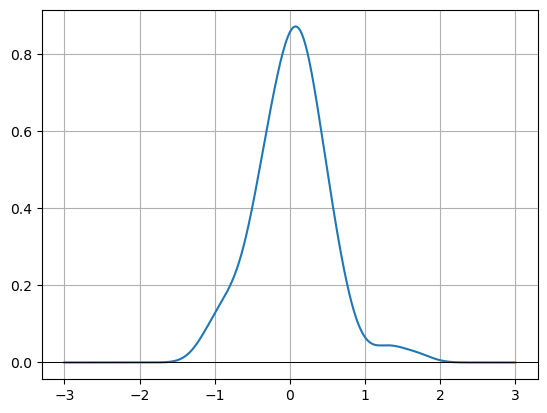

In [10]:
pdf_hats[50].plot()

In [ ]:
ks = make_kernel_functions(
    np.linspace((-trunc) * np.ones(n), trunc * np.ones(n), 10000).transpose(),
    h=0.2,
    kernel="std_normal",
)

In [ ]:
import numpy as np
from function_class import Function

kernels = {
    "epanechnikov": lambda u: 3
    / (4 * np.sqrt(5))
    * (1 - (u**2) / 5)
    * (np.abs(u) <= np.sqrt(5)),
    "uniform": lambda u: 0.5 * (np.abs(u) <= 1),
    "triangular": lambda u: (1 - np.abs(u)) * (np.abs(u) <= 1),
    "std_normal": lambda u: (1 / np.sqrt(2 * np.pi))
    * np.exp(-0.5 * u**2),  # p. 8 Li/Racine
}


def make_kernel_functions(x_vals: np.ndarray, kernel: str = "epanechnikov"):
    """Return kernel function as Function class object."""
    k = kernels[kernel]
    return [
        Function(kernel_x, kernel_y)
        for kernel_x, kernel_y in zip(x_vals, k(x_vals), strict=True)
    ]

In [ ]:
def density_estimator_better(
    x: np.ndarray,
    sample_of_points: np.ndarray,
    h: float,
    kernel_type: str = "epanechnikov",
):
    """Calculate boundary corrected density estimator from Petersen & Müller 2016."""
    def standardize(r):
        numerator = r - x[:, 0][:, np.newaxis]
        denominator = (x[:, -1][:, np.newaxis] - x[:, 0][:, np.newaxis])
        return numerator / denominator
    x_std = standardize(x)
    sample_std = standardize(sample_of_points)
    k = kernels[kernel_type]

    result = np.zeros_like(x_std)

    if sample_std.ndim > 1:
        for i, density in enumerate(sample_std):  # Looping over densities
            for point in density:  # Looping over samples for each density
                u = (x_std[i] - point) / h
                result[i, :] += k(u)
        list_of_densities = [
            (pdf_x, pdf_y) for pdf_x, pdf_y in zip(pdfs_x, pdfs_y, strict=True)
        ]
    else:
        # Add axes to make use of broadcasting rules and vectorization
        u = (pdfs_x[:, np.newaxis] - sample_of_points[np.newaxis, :]) / h
        result += np.sum(k(u), axis=1)
        pdfs_y = result / (len(sample_of_points) * h)
        list_of_densities = [
            (pdf_x, pdf_y) for pdf_x, pdf_y in zip(pdfs_x, pdfs_y, strict=True)
        ]
    return np.einsum("ij,ik->ijk", x_std, sample_std)

In [ ]:
temp = density_estimator_better(
    np.linspace(-2 * np.ones(n), 2 * np.ones(n), 10000).transpose(), sample_points, 0.2,
)

In [ ]:
temp.shape

In [ ]:
# Define the weight function w(x, h) as described in the paper Petersen & Müller 2016
def weight_function(x: np.ndarray, h: float, kernel_type: str = "epanechnikov"):
    np.zeros_like(x)
    return make_kernel_functions(x_vals=x / h, kernel=kernel_type)

    # # Case for x in [0, h)
    # # weight[mask1] =

    # # Case for x in (1-h, 1]

    # # Case for x in [h, 1-h]